# Change Point Detection Analysis

This notebook will analysis the different methods to compute change point detection in the following files. One point of analysis is how to calculate the laplacian. Different ways of calculating the laplacian changes the results of the change point detection. 

To start our analysis we must first build our networks

### Loading in data:

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from typing import Set, Tuple, List

In [2]:
def obtain_country_and_policies(df : pd.DataFrame) -> Tuple[Set, Set]:
    county_nodes = set(df["ISO2"].unique())
    policy_nodes = set(df["CTS_Name"].unique())
    
    return (county_nodes, policy_nodes)

# Load in Subsidy data
subsidy = pd.read_csv('input/policy/Fossil_Fuel_Subsidies.csv', index_col=0, keep_default_na=False, na_values="")
sub_country_nodes, sub_policy_nodes = obtain_country_and_policies(subsidy)
# print("Number of Countries:", len(subsidy_country_nodes))
# print("Number of Subsidies:", len(subsidy_policy_nodes))


# Load in green bonds
green_bonds = pd.read_csv("input/policy/Green_Bonds.csv", index_col=0, keep_default_na=False, na_values="")
# Filtered Down to countries
green_bonds = green_bonds[np.logical_not(green_bonds["ISO2"].isna())]
bond_country_nodes, bond_policy_nodes = obtain_country_and_policies(green_bonds)


# Load in Taxes
taxes = pd.read_csv("input/policy/Environmental_Taxes.csv", index_col=0, keep_default_na=False, na_values="")
tax_country_nodes, tax_policy_nodes = obtain_country_and_policies(taxes)


# Load in Expenditures:
expenditures = pd.read_csv("input/policy/Environmental_Protection_Expenditures.csv", index_col=0, keep_default_na=False, na_values="")
exp_country_nodes, exp_policy_nodes = obtain_country_and_policies(expenditures)

### Creating Multigraph

We will be constructing a dataset that includes all policy types and all 

We will create a multigraph that has attributes for each edge and node allowing us to develop our entire graph at once. Each node will have an attribute called policy, which denotes what category of policy that node is in. For country nodes, the policy attribute can have multiple values as a country can participate in multiple different policy types, but for the policy nodes there can only be one value for that policy attribute

Edges will have a single attribute, the year. Given a year, the graph will return the edges and connection between policies and countries in a given year.

Now we need to add the nodes to the graph. We will first add all the country nodes with each node having an attribute called policy that lists what policies this country have implemented. With this list we can filter down the nodes to countries that have or are currently investing in a specific policy. 

In [3]:
G = nx.MultiGraph()

# Territories are included in this.
all_countries = tax_country_nodes | exp_country_nodes | bond_country_nodes | sub_country_nodes
country_node_attributes = {}

for country in all_countries:
    policies = []
    if country in tax_country_nodes:
        policies.append("Environmental Taxes")
    if country in exp_country_nodes:
        policies.append("Environmental Protection Expenditures")
    if country in bond_country_nodes:
        policies.append("Green Bonds")
    if country in sub_country_nodes:
        policies.append("Environmental Subsidies")
        
    country_node_attributes[country] = {"bipartite" : 0, "policies" : policies}
    
G.add_nodes_from(all_countries)
nx.set_node_attributes(G,country_node_attributes)
    
# Now we will add the policy nodes using a very similar approach:
all_policies = tax_policy_nodes | exp_policy_nodes  | bond_policy_nodes  | sub_policy_nodes
policy_node_attributes = {}

for policy in all_policies:
    policies = []
    if policy in tax_policy_nodes:
        policies.append("Environmental Taxes")
    elif policy in exp_policy_nodes:
        policies.append("Environmental Protection Expenditures")
    elif policy in bond_policy_nodes:
        policies.append("Green Bonds")
    elif policy in sub_policy_nodes:
        policies.append("Environmental Subsidies")
        
    policy_node_attributes[policy] = {"bipartite" : 1, "policies" : policies}
    
G.add_nodes_from(all_policies)
nx.set_node_attributes(G, policy_node_attributes)

Now we need to add the edges between all the policies and their nodes

In [4]:
def add_edges(G : nx.MultiGraph, df : pd.DataFrame, countries : Set[str], policies : Set[str]) -> List[int]:
    """Adds the edge data from the dataframe into the graph. Returns the list of years that this policy is invested in
    
    Returns a list of years where there were policies implemented
    """
    
    # obtain the columns that correspond to the year
    years = df.filter(regex= "F\d\d\d\d", axis = 1).columns
    df_temp = df.set_index(keys = ["ISO2", "CTS_Name"])
    return_years = []
    
    edge_key = 0
    for year in years:
        year_edge_list = []
        for ind in df_temp.index:
            country = ind[0]
            policy = ind[1]
            weight = df_temp.loc[ind].at[year]
            
            if weight > 0:
                edge_data = {"weight" : weight, "year" : int(year[1:])}
                
                edge = (country, policy, edge_key, edge_data) #create edge
                year_edge_list.append(edge)
                edge_key += 1

        # Take out years with no policies
        if not (len(year_edge_list) == 0):         
            G.add_edges_from(year_edge_list)
            return_years.append(int(year[1:]))
    return return_years

taxes_sub = taxes[taxes.Unit == "Percent of GDP"].fillna(0)
tax_years = add_edges(G, taxes_sub, tax_country_nodes, tax_policy_nodes)

green_bonds_sub = green_bonds.fillna(0)
bond_years = add_edges(G, green_bonds_sub, bond_country_nodes, bond_policy_nodes)

subsidy_sub = subsidy_sub = subsidy[subsidy["Unit"] == "Percent of GDP"]
subsidy_years = add_edges(G, subsidy_sub, sub_country_nodes, sub_policy_nodes)


exp_sub = expenditures[expenditures["Unit"] == "Percent of GDP"]
exp_years = add_edges(G, exp_sub, exp_country_nodes, exp_policy_nodes)



Now that we have created a graph containing all the data, lets create methods to subgraph this multigraph so we can analysis specific policies or specific years

In [5]:
def return_subgraph_year(G : nx.MultiGraph, year : int) -> nx.MultiGraph:
    """Helper function to return the subgraph of G for the specificed year"""
    
    # If a node has no edge, it will be removed. We don't want this so we make a copy of the nodes and will add them back into the graph latter.
    sub_graph = nx.MultiGraph()
    
    # Add nodes to subgraph
    nodes = G.nodes(data=True)
    sub_graph.add_nodes_from(nodes)
    
    # Add edges to subgraph
    edges = [(u, v, key, data) for u, v, key, data in G.edges(keys=True, data=True) if data["year"] == year]
    sub_graph.add_edges_from(edges)
    
    return sub_graph

def return_subgraph_policy(G : nx.MultiGraph, filter_policy : str) -> nx.MultiGraph:
    """Helper function to return the subgraph of G for the specificed year"""
    
    sub_graph = nx.MultiGraph()
    
    # Adds subset of Nodes that are affiliated with a specific policy (Countries that take part in a type of policy)
    nodes = [(node, data) for node, data in G.nodes(data=True) if filter_policy in data["policies"]]
    sub_graph.add_nodes_from(nodes)
    
    # Adds Edges between nodes 
    node_names = sub_graph.nodes()
    edges = [(node_country, node_policy, key, data) for node_country, node_policy, key, data in G.edges(keys=True, data=True) if node_policy in node_names]
    sub_graph.add_edges_from(edges)

    return sub_graph

### Create Bidirectional Lookup table

In [6]:
# Creates a Two-way look up table
class TwoWayDict(dict):
    
    def __setitem__(self, key, value):
        # Remove any previous connections with these values
        if key in self:
            del self[key]
        if value in self:
            del self[value]
        dict.__setitem__(self, key, value)
        dict.__setitem__(self, value, key)

    def __delitem__(self, key):
        dict.__delitem__(self, self[key])
        dict.__delitem__(self, key)

    def __len__(self):
        """Returns the number of connections"""
        return dict.__len__(self) // 2
    
    def from_dict(self, user_dict):
        for key, value in user_dict.items():
            dict.__setitem__(self, key, value)
            dict.__setitem__(self, value, key)
    

In [13]:
# Create Country Name Lookup Table
country_name_conversion = pd.read_csv("input/wikipedia-iso-country-codes.csv")
country_name_conversion.rename(columns = {"English short name lower case" : "Country Name", "Alpha-2 code" : "ISO2", "Alpha-3 code" : "ISO3"}, inplace = True)

two_way_country_lookup = TwoWayDict()
oneway_lookup = country_name_conversion.set_index("Country Name")["ISO2"].to_dict()
two_way_country_lookup.from_dict(oneway_lookup)

### Change Point Detection

In [8]:
from typing import Callable

def standard_laplacian(G: nx.MultiGraph) -> np.ndarray:
    return nx.normalized_laplacian_matrix(G).toarray()

def signless_laplacian(G:  nx.MultiGraph) -> np.ndarray:
    A = nx.adjacency_matrix(G)
    D = np.diag(nx.laplacian_matrix(G).diagonal())

    return A + D

# TODO: Ask Dr. Srini about this.
def normalized_signless_laplacian(G:  nx.MultiGraph) -> np.ndarray:

    laplac = signless_laplacian(G)
    
    max_value = np.max(laplac)
    return laplac / max_value
    # D = np.diag(nx.laplacian_matrix(G).diagonal())
    # squared_D = np.linalg.matrix_power(D, 2)
    # inv_D = np.linalg.inv(squared_D)
    
    # norm_laplac = inv_D @ laplac @ inv_D

    # return norm_laplac



# TODO: Add citation to the paper I got this information from
def compute_year_signature(G : nx.MultiGraph, laplacian_func: Callable) -> np.ndarray:
    """_summary_

    Args:
        G (nx.MultiGraph): A Multigraph subgraph that depicts a specific year of a graph.
        
        laplacian_func (Callable): Either the normal laplacian or the signless laplacian

    Returns:
        np.ndarray: Returns a numpy array containing a numeric signature of a year
    """
    
    laplacian = laplacian_func(G)
    singular_values = np.linalg.svd(laplacian)[1]
    l2_norm = np.linalg.norm(singular_values, ord = 2)
    norm_singluar_values = singular_values / l2_norm
    
    return norm_singluar_values
    

def change_point_detection(windowSize: int, G : nx.MultiGraph, years : List[int], laplacian_func: Callable) -> Tuple[List[float], List[int]]:
    """
    Given series of network graphs

    Args:
        windowSize (int): _description_
        G (MultiGraph): A networkx Multigraph that has a single policy attribute across all nodes
        years (List[int]): A list of years to compute change detection over

    Returns:
        _type_: _description_
    """

    dict_signatures = {}
    # Compute the signatures for each person
    for year in years:
        sub_G = return_subgraph_year(G, year)
        dict_signatures[year] = compute_year_signature(sub_G, laplacian_func)


    window_dicts = {}
    for i in range(len(years) - windowSize):
        year_subset = years[i:i+windowSize]

        weights_avg_list = []

        for year in year_subset:
            weights_avg_list.append(dict_signatures[year])
    
        weights_avg = np.stack(weights_avg_list, axis = 1).mean(axis = 1)

        window_dicts[years[windowSize + i]] = weights_avg / np.linalg.norm(weights_avg, ord = 2)
        

    Z_list = []
    year_list = []

    for year in window_dicts.keys():
        baseline = window_dicts[year]
        single_year = dict_signatures[year]

        Z = 1-np.transpose(single_year) @ baseline

        Z_list.append(Z)
        year_list.append(year)

    return (Z_list, year_list)
    

In [9]:
policy_G = return_subgraph_policy(G, "Green Bonds")
year_G = return_subgraph_year(policy_G, 2021)

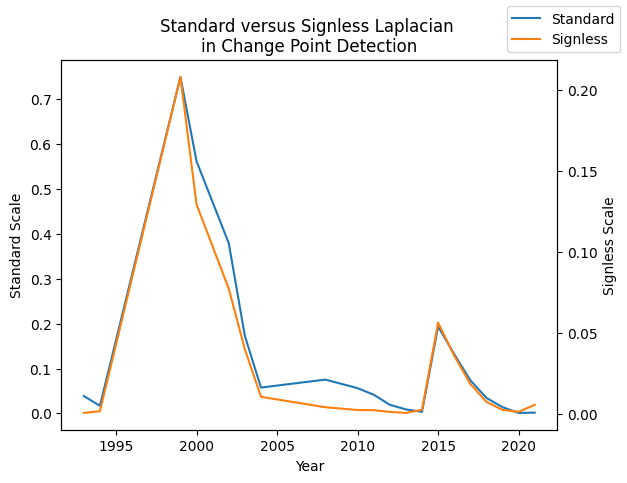

In [10]:
import matplotlib.pyplot as plt
from copy import deepcopy

# ("Environmental Taxes")
# ("Environmental Protection Expenditures")
# ("Green Bonds")
# ("Environmental Subsidies")

window_size = 5
# sub_G = return_subgraph_policy(G, "Green Bonds")
G_copy = deepcopy(G)
years = bond_years

Z_list_signless, year_list_signless = change_point_detection(window_size, G_copy, years, normalized_signless_laplacian)
Z_list_stand, year_list_stand = change_point_detection(window_size, G_copy, years, standard_laplacian)


fig, ax1 = plt.subplots()

ax1.plot(year_list_stand, Z_list_stand, label = "Standard",  c = "C0")
ax1.set_xlabel("Year")
ax1.set_ylabel("Standard Scale")

ax2 = ax1.twinx()
ax2.plot(year_list_signless, Z_list_signless, label = "Signless", c = "C1")
ax2.set_ylabel("Signless Scale")

ax1.set_title("Standard versus Signless Laplacian \nin Change Point Detection")
fig.legend(loc = 1)


From the graphs above it appears that the signless laplacian places more weight on the change in the year 2000. This is very interesting.

In [11]:
cols = green_bonds.columns[[0,1,2,3,4,5,12,13,14,15,16,17,18,19,20,21,22,23, 24, 25]]

test_data = green_bonds[cols]
test_data[test_data.filter(regex="F199\d").isna().sum(axis = 1) < 6]

,Country,ISO2,ISO3,Indicator,Unit,Source,F1985,F1986,F1987,F1990,F1991,F1992,F1993,F1994,F1999,F2000,F2002,F2003,F2004,F2007
ObjectId,,,,,,,,,,,,,,,,,,,,
29,France,FR,FRA,Green Bond Issuances by Country,US Dollars,Refinitiv. Accessed on 2022-03-29; Country aut...,NaN,0.3,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Germany,DE,DEU,Green Bond Issuances by Country,US Dollars,Refinitiv. Accessed on 2022-03-29; Country aut...,NaN,NaN,NaN,NaN,0.029179,0.035015,0.017508,NaN,NaN,0.027218,NaN,0.349752,NaN,NaN
44,Italy,IT,ITA,Green Bond Issuances by Country,US Dollars,Refinitiv. Accessed on 2022-03-29; Country aut...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048174,0.026103,NaN,NaN,NaN,NaN
88,Switzerland,CH,CHE,Green Bond Issuances by Country,US Dollars,Refinitiv. Accessed on 2022-03-29; Country aut...,NaN,NaN,NaN,NaN,NaN,0.108531,0.168143,0.109745,NaN,NaN,0.108061,NaN,NaN,NaN


In [12]:
policy_G = return_subgraph_policy(G, "Green Bonds")
year_G = return_subgraph_year(policy_G, 2021)
year_G.edges(data = True)

MultiEdgeDataView([('AE', 'Green Bonds Issuances', {'weight': 0.593267, 'year': 2021}), ('PL', 'Green Bonds Issuances', {'weight': 1.132105, 'year': 2021}), ('RU', 'Green Bonds Issuances', {'weight': 1.062672, 'year': 2021}), ('CZ', 'Green Bonds Issuances', {'weight': 0.9622896, 'year': 2021}), ('IL', 'Green Bonds Issuances', {'weight': 1.0, 'year': 2021}), ('HU', 'Green Bonds Issuances', {'weight': 0.8961061, 'year': 2021}), ('HU', 'Green Bonds', {'weight': 0.4566329, 'year': 2021}), ('VN', 'Green Bonds Issuances', {'weight': 0.2, 'year': 2021}), ('FI', 'Green Bonds Issuances', {'weight': 4.035055, 'year': 2021}), ('IE', 'Green Bonds Issuances', {'weight': 5.1524, 'year': 2021}), ('MX', 'Green Bonds Issuances', {'weight': 0.0707396, 'year': 2021}), ('CH', 'Green Bonds Issuances', {'weight': 1.817689, 'year': 2021}), ('DK', 'Green Bonds Issuances', {'weight': 7.263042, 'year': 2021}), ('IS', 'Green Bonds Issuances', {'weight': 1.018895, 'year': 2021}), ('LU', 'Green Bonds Issuances', {

# How to Use New Graph

This week I was able to create a graph that contained all the nodes and edges across all the graphs and years. It is very simple to subset and is much faster to create than creating many smaller separate graphs. Here is how it works:

The first thing you need to know is the attributes in the graph as they are the metadata that tells us what type of policy or year a node / edge is apart of. The attributes for nodes are different from edges. The node attribute has two keys, the bipartite key, which is 0 for country and 1 for policy (like we had it before), and the policies key, which is a list of policies a node takes part in. Here are two examples:

***US Node:***

`` "US" : {'bipartite': 0, 'policies': ['Environmental Taxes', 'Green Bonds', 'Environmental Subsidies']} ``

***A Policy Node from the Tax Policy Category:***

`` "Taxes on Energy (Including Fuel for Transport)" : {'bipartite': 1, 'policies': ['Environmental Taxes']} ``


These examples illustrate a key point. First, a country node, like the US, can belong to multiple policies, while a policy node can only belond to a single type of policy. We will get to the importance in one second.

The edge attribute is a bit more complex though. The edge attributes consists of the weight, which is simply the weight of the edge, and year, which is the year in which this data comes from:

***US to Green Bonds Issuance Edge:***

``('US', 'Green Bonds Issuances', {'weight': 61.4917, 'year': 2021})``

You might be wondering why there is no policy attribute here, and the answer is we don't need it from the key observation we made early. Since policy nodes are always bound to a single policy and can't coexist in two different policies, if we subset our data to only include policy nodes of a specific type, lets say green bonds, then only the edges that connect to a node in green bonds will stay. Since all the none green bond nodes will disappear, the edges to connecting all these nodes will also disappear. So when we subset by a policy on the whole graph, we are left with the correct graph for that policy.

To subset we can use the two functions I made:

In [ ]:
# Subsets the graph to single policy the options are (Environmental Taxes, Environmental Protection Expenditures, Green Bonds, Environmental Subsidies)
policy_G = return_subgraph_policy(G, "Green Bonds")

# Subsets the graph to single year
year_G = return_subgraph_year(G, 2021)

Using the above functions we can subset a graph to a single policy or to a single year. We can even combine them to subset to a single policy and single year:

In [ ]:
policy_G = return_subgraph_policy(G, "Green Bonds")
year_policy_G = return_subgraph_year(policy_G, 2021)

By using this method we have much more flexibility than before and can easily create graphs we were never able to make before. But the last thing missing is a few key variables. 

If you played around with the year function graph you might figured out you can put in absolutly any integer and the function will work. If there is no corresponding year to your input, it will just return a graph with all the nodes from your specified policy (or entire graph) but with no edges.

In [ ]:
year_G = return_subgraph_year(G, year = 20000000)

num_nodes = len(year_G.nodes())
num_edges = len(year_G.edges())

print(f"Number of Nodes : {num_nodes}, Number of Edges : {num_edges}")

Number of Nodes : 240, Number of Edges : 0


So to solve this problem I created a list of all the valid years for each type of policy. They are all set types so you can manipulate them fairly easily if you want to Union or And different policiy years:

In [ ]:
print(f"Tax Years: {tax_years}\n")
print(f"Expenditure Years: {exp_years}\n")
print(f"Green Bond Years: {bond_years}\n")
print(f"Subsidy Years: {subsidy_years}\n")

Tax Years: [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

Expenditure Years: [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

Green Bond Years: [1985, 1986, 1987, 1991, 1992, 1993, 1994, 1999, 2000, 2002, 2003, 2004, 2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

Subsidy Years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]



Hopefully this works out and can easily be integrated with your work. Also hope this all makes sense.

The last thing I wanted to say is I currenlty haven't set up the graph to take in a list of years or policies to subset a graph currently. So you can't make a single graph with the years [2020 - 2023] or so on

### Two way Look up

Also I almost forgot to mention that I made a two way lookup table for country names and ISO names. I made a brand new class and downloaded data from the web. I think I am just going to send this notebook to you so if you want to download the csv for the look up table you can at https://gist.github.com/radcliff/f09c0f88344a7fcef373

In [14]:
two_way_country_lookup["US"]

'United States'

In [16]:
two_way_country_lookup['United States']

'US'